In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import sys
import os

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [26]:
import pandas as pd
from src.config import TRANSFORMED_DATA_DIR

df = pd.read_parquet(TRANSFORMED_DATA_DIR / "tabular_data.parquet")

In [27]:
# Assuming pickup_hour is in datetime format, extract useful time features
df['pickup_hour'] = pd.to_datetime(df['pickup_hour'])
df['week_day'] = df['pickup_hour'].dt.weekday  # Capture weekly patterns
df['hour_of_day'] = df['pickup_hour'].dt.hour  # Capture daily patterns

In [28]:
selected_lags = ['rides_t-1', 'rides_t-2', 'rides_t-3', 'rides_t-24', 'rides_t-168', 'rides_t-672']
features = selected_lags + ['week_day', 'hour_of_day']
target = 'target'


In [29]:
train_size = int(0.8 * len(df))
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [30]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

# Fit ARMA(1,2) without differencing (d=0)
arma_order = (1, 0, 2)
arma_model = ARIMA(train[target], order=arma_order, exog=train[features]).fit()
arma_preds = arma_model.forecast(steps=len(test), exog=test[features])
arma_mae = mean_absolute_error(test[target], arma_preds)

print(f"ARIMA{arma_order} MAE: {arma_mae}")


c:\Users\vidyu\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 2) MAE: 4.000967156221908



Best Model: ARIMA, MAE: 3.0725831106091506


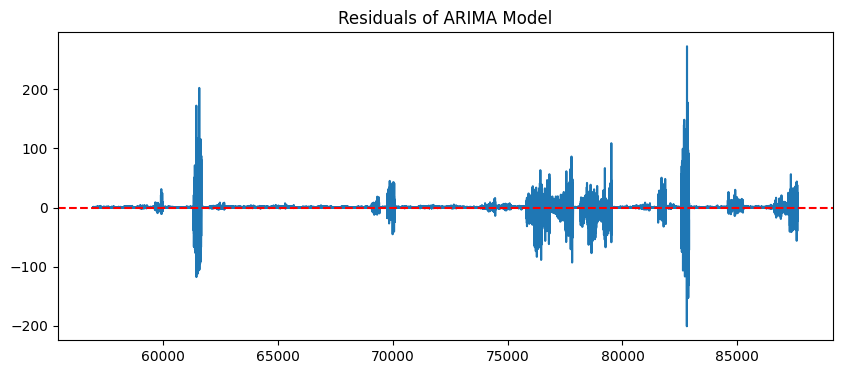

In [19]:
import matplotlib.pyplot as plt 

best_model, best_mae, best_preds = 'ARIMA', arma_mae, arma_preds
print(f"\nBest Model: {best_model}, MAE: {best_mae}")

# ===========================
# Residual Analysis
# ===========================
residuals = test[target] - best_preds
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='red')
plt.title(f"Residuals of {best_model} Model")
plt.show()

In [31]:
# Get in-sample predictions for training data
train_preds = arma_model.fittedvalues  

# Calculate train MAE
train_mae = mean_absolute_error(train['target'], train_preds)

print(f"Train MAE: {train_mae}")


Train MAE: 3.1773172239614182


In [32]:
from src.experiment_utils import set_mlflow_tracking, log_model_to_mlflow
from dotenv import load_dotenv
import mlflow
import mlflow.sklearn  # Needed for logging non-sklearn models too
import os

load_dotenv()

# Set MLflow tracking
mlflow = set_mlflow_tracking()

# Train ARIMA model
arma_order = (1, 0, 2)
arma_model = ARIMA(train[target], order=arma_order, exog=train[features]).fit()

# Forecasting
arma_preds = arma_model.forecast(steps=len(test), exog=test[features])
test_mae = mean_absolute_error(test[target], arma_preds)

# In-sample training error
train_preds = arma_model.fittedvalues  
train_mae = mean_absolute_error(train[target], train_preds)

# Log model & metrics to MLflow
with mlflow.start_run():
    mlflow.log_param("model_type", "ARIMA")
    mlflow.log_param("order", arma_order)
    mlflow.log_metric("train_mae", train_mae)
    mlflow.log_metric("test_mae", test_mae)

    # Log the model
    mlflow.sklearn.log_model(arma_model, "ARIMA_Model")

print(f"Logged ARIMA({arma_order}) to MLflow with Train MAE: {train_mae}, Test MAE: {test_mae}")


INFO:src.experiment_utils:MLflow tracking URI and credentials set.
c:\Users\vidyu\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
2025/02/23 20:52:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run selective-auk-350 at: https://dagshub.com/vidyuthkrishna03/nyc-taxi-rides-prediction.mlflow/#/experiments/0/runs/10273e9adfe14e938e9cab09b7a3ad48
🧪 View experiment at: https://dagshub.com/vidyuthkrishna03/nyc-taxi-rides-prediction.mlflow/#/experiments/0
Logged ARIMA((1, 0, 2)) to MLflow with Train MAE: 3.1773172239614182, Test MAE: 4.000967156221908
